<center>

*******************************************************************************************
<font size="4">
Artificial Neural Network &nbsp; &nbsp; <br>
Regression  &nbsp; <br>
</font>

##### 29 December 2025

##### Juan Ignacio Mendoza Garay

*******************************************************************************************

</center>

##### INFORMATION:

* Demonstration of an artificial neural network for solving a regression problem.
>
* The neural network is a multi-layer perceptron composed by:

    * Input layer: one node per independent variable (i.e., feature)
    * Hidden layer 1: 2 nodes and bias, ReLU activation
    * Hidden layer 2: 2 nodes and bias, ReLU activation
    * Output layer: 1 node and bias, identity activation (i.e., none)
>
* Instructions:

    Edit the values indicated with an arrow like this: <--- \
    Run the program, close your eyes, and hope for the best.

*******************************************************************************************

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

seed = 1 # <--- pseudo-random generators' seed

>
### Generate data

In [2]:
n_iv = 5      # <--- number of independent variables
n_obs = 12    # <--- number of observations
f_train = 0.8 # <--- proportion of training observations (the rest are for testing)
shuffle = 1   # <--- seed for shuffling the train/test split

data = []
rng_1 = np.random.default_rng(seed=seed)
ran_d = np.sort( rng_1.integers(low=1, high=100, size=n_iv) )
ran_f = rng_1.integers(low=1, high=1000, size=n_iv)
for i in range(n_obs):
    rng_2 = np.random.default_rng(seed=i)
    x = ran_d + rng_2.integers(low=0, high=80, size=n_iv) # independent variables
    data.append(np.append( x, np.dot(x, ran_f ))) # last element is dependent variables
rng_shuf = np.random.default_rng(seed=shuffle)
data_shuf = rng_shuf.choice(data, size=n_obs, replace=False)

data_train = data_shuf[:int(len(data)*f_train)]
data_test = data_shuf[int(len(data)*f_train):]

print('TRAINING DATA:\n               X                    y   ')
for obs in data_train: print( ''.join([f'| {v:<3} ' for v in obs[:-1]]) + f'| | {obs[-1]:<6} |')
print('\nTESTING DATA:\n               X                    y   ')
for obs in data_test: print( ''.join([f'| {v:<3} ' for v in obs[:-1]]) + f'| | {obs[-1]:<6} |')

TRAINING DATA:
               X                    y   
| 14  | 57  | 114 | 114 | 142 | | 229703 |
| 41  | 87  | 111 | 151 | 97  | | 250637 |
| 37  | 116 | 127 | 97  | 104 | | 277830 |
| 39  | 90  | 92  | 102 | 170 | | 245379 |
| 72  | 97  | 91  | 96  | 119 | | 237571 |
| 79  | 97  | 105 | 146 | 141 | | 271172 |
| 62  | 122 | 121 | 115 | 170 | | 305779 |
| 66  | 123 | 72  | 91  | 158 | | 251010 |
| 71  | 67  | 59  | 98  | 128 | | 185706 |

TESTING DATA:
               X                    y   
| 61  | 73  | 69  | 153 | 109 | | 206441 |
| 68  | 53  | 65  | 93  | 109 | | 172264 |
| 57  | 111 | 52  | 139 | 132 | | 224709 |


>
### Functions

In [3]:
def init_weights(n_in, n_out, seed=0):
    '''He initialisation (preferred for ReLU activations)'''
    rng = np.random.default_rng(seed=seed)
    return  rng.normal(size=(n_in,n_out)) * np.sqrt(2 / n_in)

def hidden_activation(z, deriv=False):
    '''
    If deriv=False: ReLU (rectified linear unit). Equivalent to numpy.maximum(z,0)
    Else: Unit step (derivative of ReLU). Equivalent to numpy.heaviside(z,0)
    '''
    if deriv:
        z[z > 0] = 1
        z[z <= 0] = 0
    else:
        z[z < 0] = 0
    return z

def output_activation(z, deriv=False):
    '''
    If deriv=False: identity (linear)
    Else: 1
    '''
    if deriv: return 1 # for completeness :P
    else: return z

def feed_forward(layers, weights, biases):

    h1_in = np.dot(layers['input'], weights['w0']) + biases['b0'] # first layer plus bias
    layers['h1_out'] = hidden_activation(h1_in)

    h2_in = np.dot(layers['h1_out'], weights['w1']) + biases['b1'] # second layer plus bias
    layers['h2_out'] = hidden_activation(h2_in)

    out_in = np.dot(layers['h2_out'], weights['w2']) + biases['b2'] # output layer plus bias
    layers['out'] = output_activation(out_in)

    return layers, weights, biases

>
### Training

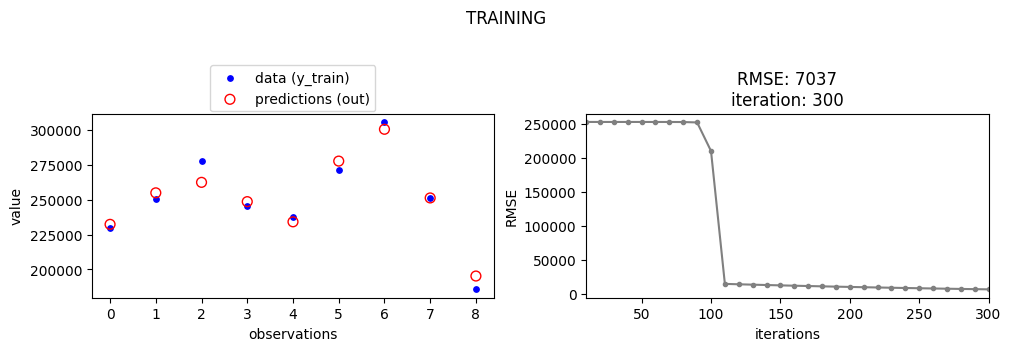

TRAINING:
 data = [[229703] [250637] [277830] [245379] [237571] [271172] [305779] [251010] [185706]]
 pred = [[232335] [254936] [262457] [248627] [234145] [277705] [300530] [251274] [195265]]


In [4]:
n_iterations = 300       # <---
plot_step = 10           # <---
learning_rate = 1/10**10 # <---

# ..................................................................................................
# Initialise weights and biases:

weights = {}
biases = {}

weights['w0'] = init_weights(n_iv,2)
biases['b0'] = np.zeros(2)

weights['w1'] = init_weights(2,2)
biases['b1'] = np.zeros(2)

weights['w2'] = init_weights(2,1)
biases['b2'] = np.zeros(1)

# ..................................................................................................

X_train = data_train[:,:-1]
y_train = np.expand_dims(data_train[:,-1],1)
layers_train = {'input':X_train}
rmse_all = []
plot_idx = []
y_linspc = list(range(len(y_train)))
y_max_ = np.sort(y_train)[-2]
for i in range(1,n_iterations + 1):

    # ..............................................................................................
    # feed forward:

    layers_train, weights, biases = feed_forward(layers_train, weights, biases)
    if np.isnan(layers_train['out'][0]) or (abs(layers_train['out'][0]) == np.inf):
        raise Exception('Exploded at i =',i)

    # ..............................................................................................
    # back propagation:

    # d_error is the scaled derivative of SE (SE = (out-y_train)**2; SE' = 2*(out-y_train)**1 )
    d_error = layers_train['out'] - y_train
    d_out = d_error * output_activation(layers_train['out'], deriv=True)

    weights['w2'] -= np.dot(layers_train['h2_out'].T, d_out) * learning_rate
    biases['b2'] -= np.sum(d_out, axis=0) * learning_rate
    d_2 = np.dot(d_out, weights['w2'].T) * hidden_activation(layers_train['h2_out'], deriv=True)

    weights['w1'] -= np.dot(layers_train['h1_out'].T, d_2) * learning_rate
    biases['b1'] -= np.mean(d_2, axis=0) * learning_rate
    d_1 = np.dot(d_2, weights['w1'].T) * hidden_activation(layers_train['h1_out'], deriv=True)

    weights['w0'] -= np.dot(layers_train['input'].T, d_1) * learning_rate
    biases['b0'] -= np.mean(d_1, axis=0) * learning_rate

    # ..............................................................................................
    # visualisation:

    if (i % plot_step == 0) or (i == n_iterations):

        plot_idx.append(i)
        rmse = np.mean(d_error**2)**0.5
        rmse_all.append(rmse)

        clear_output(wait=True)
        plt.rcParams['figure.constrained_layout.use'] = True
        plt.figure(figsize=(10,2.8))

        plt.subplot(1,2,1)
        plt.scatter(y_linspc, y_train, 15, color='blue')
        plt.scatter(y_linspc, layers_train['out'], 50, marker='o',facecolors='none',edgecolors='red')
        plt.legend(['data (y_train)','predictions (out)'], loc='upper center', bbox_to_anchor=(0.5,1.3))
        plt.ylabel('value')
        plt.xlabel('observations');

        plt.subplot(1,2,2)
        plt.plot(plot_idx, rmse_all, '.-', color='gray')
        plt.xlim(plot_step,n_iterations)
        plt.ylabel('RMSE')
        plt.xlabel('iterations')
        plt.title(f'RMSE: {int(rmse)}\niteration: {i}')

        plt.suptitle('TRAINING',y=1.2)
        plt.show()

print('TRAINING:')
print(f' data = {y_train.astype(int)}'.replace('\n',''))
print(f' pred = {layers_train["out"].astype(int)}'.replace('\n',''))

# Note:
# SE = Squared Error
# RMSE = Root Mean Squared Error

>
### Testing

In [6]:
X_test = data_test[:,:-1]
y_test = data_test[:,-1]

out_test = []
for x, y in zip(X_test,y_test):
    layers_test, _, _ = feed_forward({'input':x}, weights, biases)
    out_test.append(layers_test['out'][0])
out_test = np.array(out_test)

print('TESTING:')
print(f' data = {y_test.astype(int)}'.replace('\n',''))
print(f' pred = {out_test.astype(int)}'.replace('\n',''))
print(f' RMSE = {int(np.mean((out_test - y_test)**2)**0.5)}')

TESTING:
 data = [206441 172264 224709]
 pred = [224177 179298 240700]
 RMSE = 14373
